In [87]:
# Использован HOG из состава openCV
# будет переделан  на самописный
# сегодня будет закончено 

In [1]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
train = np.loadtxt('digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

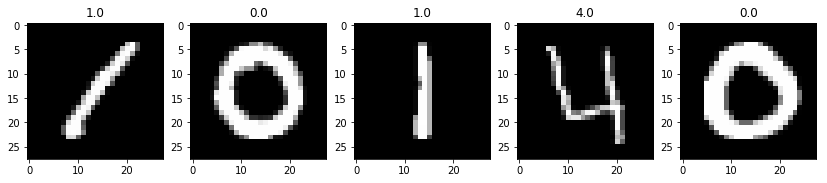

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


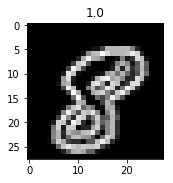

In [6]:
fig = plt.figure(figsize=(20, 10))
kernel = np.array([[1,0,-1]])
kernel2 = np.array([[1],[0],[-1]])

for i, img in enumerate(train_img[10:11], 1):
    subplot = fig.add_subplot(1, 7, i)
    dx = cv2.filter2D(img,-1,kernel)
    dy = cv2.filter2D(img,-1,kernel2)
    g = np.sqrt(dx*dx + dy*dy)
    tetta = np.arctan(dy/dx)
    #print(dst)
    plt.imshow(g, cmap='gray');
    #plt.imshow(tetta, cmap='gray')
    subplot.set_title('%s' % train_label[i - 1]);



## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [46]:
#  не используется

train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [9]:

kernel = np.array([[-1,0,1]])
kernel2 = np.array([[-1],[0],[1]])

train_filter_x = np.zeros_like(train_img)
train_filter_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_filter_x[i] = cv2.filter2D(train_img[i],-1,kernel)
    train_filter_y[i] = cv2.filter2D(train_img[i],-1,kernel2)

test_filter_x = np.zeros_like(test_img)
test_filter_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_filter_x[i] = cv2.filter2D(test_img[i],-1,kernel)
    test_filter_y[i] = cv2.filter2D(test_img[i],-1,kernel2)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

NameError: name 'train_sobel_x' is not defined

In [85]:
# Использование алгоритма HOG из состава OpenCV
winSize = (28,28)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (4,4)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradient = True
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

train_hist = []
test_hist = []


for i in range(len(train_sobel_x)):
    train_img_p = train_filter_x[i].astype(np.uint8)
    train_hist.append(hog.compute(train_img_p).reshape(-1))

for i in range(len(test_sobel_x)):
    test_img_p = test_filter_x[i].astype(np.uint8)
    test_hist.append(hog.compute(test_img_p).reshape(-1))


train_hist = np.array(train_hist)
test_hist = np.array(test_hist) 

print(train_hist.shape)    
    
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(train_label, train_hist, test_size=0.2, random_state=42)    

(42000, 1296)


In [ ]:
# HOG сделанный в ручную

# в соответствии со статьей https://www.learnopencv.com/histogram-of-oriented-gradients/
# 1) разобъем картинки на части 
# 2) посчитаем для этих частей диаграммы градиентов
# 3) соберем эти части в группы 
# 4) проведем для полученных групп нормалицацию
# 5) полученные группы переведем в вектора и сложим в единый большой вектор
# 6) для получившихся данных проведем классификацию
#

In [10]:
train_filter = np.sqrt(train_filter_x*train_filter_x+train_filter_y*train_filter_y)
train_tetta = np.arctan(train_filter_y/train_filter_x)*180/np.pi+90
train_tetta = np.nan_to_num(train_tetta)

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## Вычисляем гистограммы градиентов

In [12]:


d_hog = 4 # размер части
c_hog = 8 # размер группы 
bins = 9  # количество бинов 

size_x = train_filter[0].shape[0]//d_hog
size_y = train_filter[0].shape[1]//d_hog
print(size_x,size_y)
result_hist = [[[0]*size_x]*size_y]*len(train_filter)

delta = 180 / bins

for n in range(len(train_filter)):
    if n%5000 == 0:
        print(n)
    for i in range(size_x):
        for j in range(size_y):
            part_g = train_filter[n][i*d_hog:(i+1)*d_hog, j*d_hog:(j+1)*d_hog]
            part_t = train_tetta[n][i*d_hog:(i+1)*d_hog, j*d_hog:(j+1)*d_hog]
            res_part = [0.0]*bins
            #print(res_part)
            for k in range(part_g.shape[0]):
                for m in range(part_g.shape[1]):
                    #print('---',k,m)
                    p, t = int(part_t[k][m]//delta), part_t[k][m]%delta/delta
                    #print('part',part_t[k][m])
                    g_1 = (part_g[k][m]/delta) * t
                    #print('gl',g_1)
                    res_part[p % (bins)]+= g_1
                    res_part[(p+1) % (bins)] += part_g[k][m] - g_1
                    #print(p % (bins),res_part)
            #print(res_part)        
            result_hist[n][i][j] = res_part
         


7 7
0
5000
10000
15000
20000
25000
30000
35000
40000


In [88]:
result_hist = np.array(result_hist)
print(result_hist.shape)

result_hist1 = np.concatenate([result_hist[:,:,:-1,:],result_hist[:,:,1:,:]],axis=3)
print(result_hist1.shape)

result_hist2 = np.concatenate([result_hist1[:,:-1,:,:],result_hist1[:,1:,:,:]],axis=3)
print(result_hist2.shape)

(42000, 7, 7, 9)
(42000, 7, 6, 18)
(42000, 6, 6, 36)


In [103]:
norm_vect = np.sqrt(np.sum(result_hist2*result_hist2, axis=3))

In [110]:
result_hist3 = np.nan_to_num(result_hist2/norm_vect[:,:,:, np.newaxis])

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [112]:
result_hist3.shape

(42000, 6, 6, 36)

In [118]:
6*6*36

1296

In [117]:
sh = np.array(result_hist3.shape)

np.prod(sh[1:])

1296

In [119]:
result_hist4 = result_hist3[:,:].reshape(sh[0],np.prod(sh[1:]))

In [120]:
result_hist4.shape 

(42000, 1296)

## Нормируем вектор гистограммы

In [60]:
#  не используется
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [78]:
#  не используется
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)



## Собираем полносвязную сеть для обучения

In [75]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32,
                             input_dim=x_train.shape[1],
                             activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                41504     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 41,834
Trainable params: 41,834
Non-trainable params: 0
_________________________________________________________________


## One hot encoding разметки

In [60]:
y_train.shape

(33600,)

In [61]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

## Запускаем обучение

In [76]:
model.fit(x_train, y_train_labels, 
          batch_size=32, validation_split=0.2,
          epochs=10)

Train on 26880 samples, validate on 6720 samples
Epoch 1/10
26880/26880 [==============================] - 4s 141us/step - loss: 0.3905 - acc: 0.9009 - val_loss: 0.1682 - val_acc: 0.9518
Epoch 2/10
26880/26880 [==============================] - 3s 102us/step - loss: 0.1358 - acc: 0.9593 - val_loss: 0.1247 - val_acc: 0.9625
Epoch 3/10
26880/26880 [==============================] - 3s 102us/step - loss: 0.1061 - acc: 0.9668 - val_loss: 0.1093 - val_acc: 0.9668
Epoch 4/10
26880/26880 [==============================] - 3s 110us/step - loss: 0.0906 - acc: 0.9714 - val_loss: 0.1101 - val_acc: 0.9643
Epoch 5/10
26880/26880 [==============================] - 3s 111us/step - loss: 0.0785 - acc: 0.9757 - val_loss: 0.0995 - val_acc: 0.9693
Epoch 6/10
26880/26880 [==============================] - 3s 104us/step - loss: 0.0704 - acc: 0.9779 - val_loss: 0.1042 - val_acc: 0.9683
Epoch 7/10
26880/26880 [==============================] - 3s 104us/step - loss: 0.0643 - acc: 0.9793 - val_loss: 0.0962 - v

In [63]:
y_train_labels.shape

(33600, 10)

In [64]:
x_train.shape

(33600, 1296, 1)

## Предсказываем класс объекта

In [83]:
#  не используется
from sklearn.linear_model import LogisticRegression
cls = LogisticRegression()
cls.fit(x_train, y_train)

x_pred = cls.predict(x_val)

from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, x_pred))


/home/user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/user/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 0.5352380952380953


In [77]:
pred_val = model.predict_classes(x_val)

In [78]:
pred_proba = model.predict_proba(x_val)

## Оцениваем качество решение на валидационной выборке

In [79]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.9686904761904762


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       816
         1.0       0.98      0.99      0.98       909
         2.0       0.97      0.97      0.97       846
         3.0       0.94      0.98      0.96       937
         4.0       0.97      0.97      0.97       839
         5.0       0.99      0.95      0.97       702
         6.0       0.97      0.99      0.98       785
         7.0       0.97      0.96      0.97       893
         8.0       0.95      0.97      0.96       835
         9.0       0.96      0.95      0.95       838

   micro avg       0.97      0.97      0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [81]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[789   0   6   3   1   1   6   1   8   1]
 [  0 897   3   1   0   0   4   2   2   0]
 [  0   6 817   9   4   0   0   4   6   0]
 [  0   0   4 922   0   0   0   4   3   4]
 [  1   0   1   1 812   0   4   2   5  13]
 [  0   1   1  25   1 664   7   0   3   0]
 [  1   1   1   0   0   1 776   0   5   0]
 [  0   5   4   6   5   0   0 859   3  11]
 [  1   4   2  10   1   2   1   2 809   3]
 [  2   2   3   4  11   2   0  13   9 792]]


## Предсказания на тестовыйх данных

In [82]:
pred_test = model.predict_classes(test_hist)

## Визуализируем предсказания

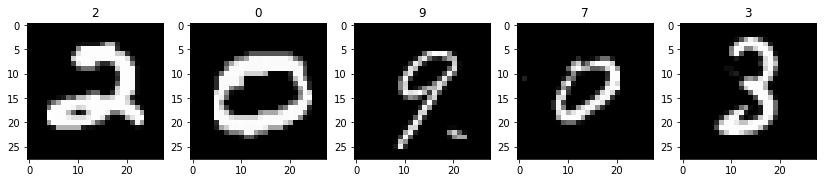

In [83]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [84]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

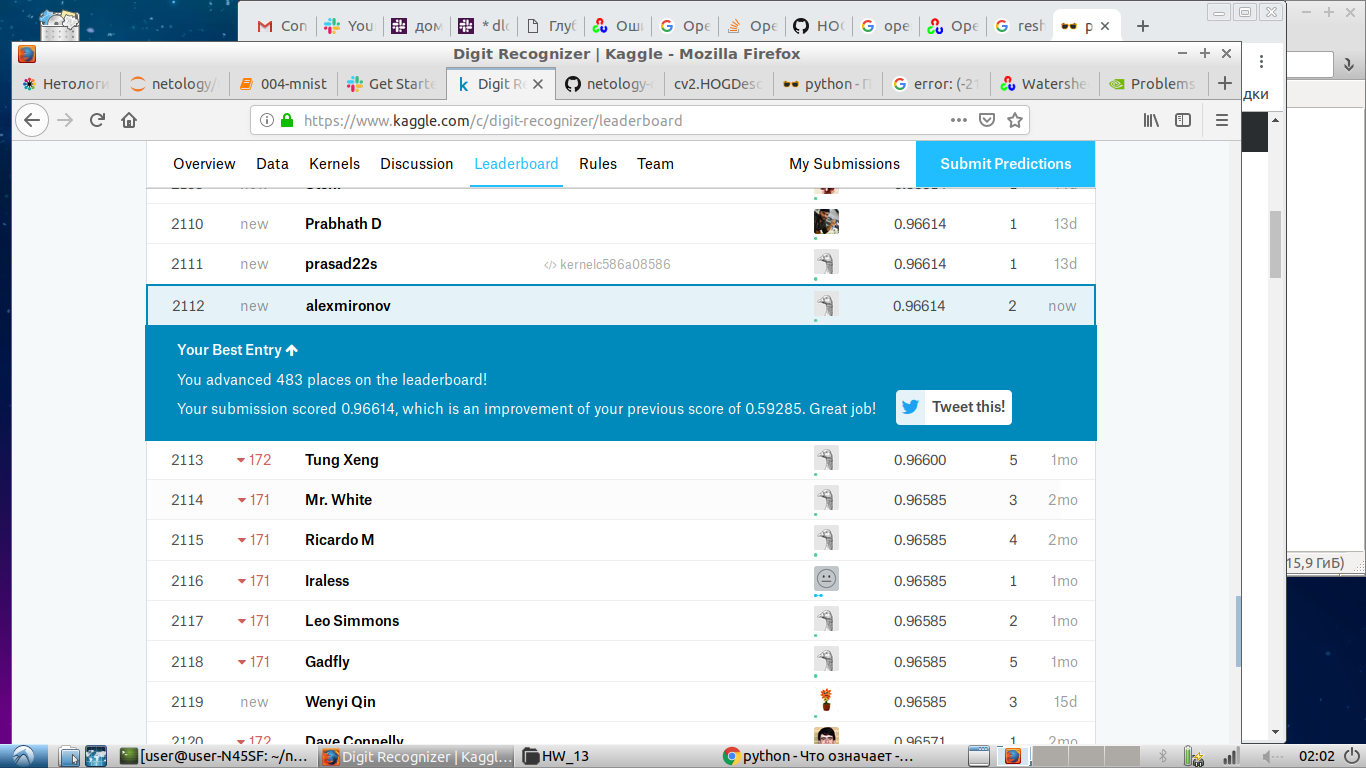

In [88]:
from IPython.display import Image
Image("commit_hog_from_box.png")